<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:09:55] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


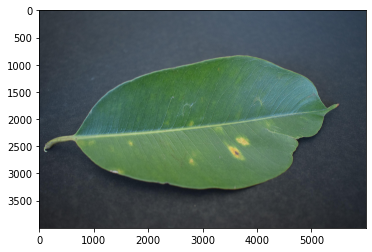

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

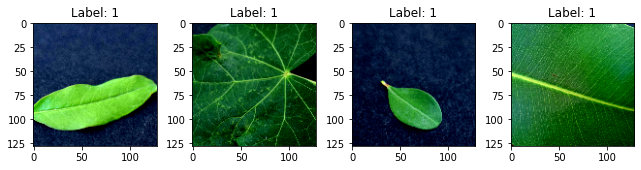

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:10:01] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:10:03] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.25096343150726 samples/sec                   batch loss = 0.2809205651283264 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2581767688228755 samples/sec                   batch loss = 1.0339008569717407 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.267114625986595 samples/sec                   batch loss = 1.1283483505249023 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2662389067782571 samples/sec                   batch loss = 0.9007039070129395 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2644723200420616 samples/sec                   batch loss = 0.3103676438331604 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.26754120872479 samples/sec                   batch loss = 0.7164328694343567 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2536093764021852 samples/sec                   batch loss = 0.5669689178466797 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2675249289788717 samples/sec                   batch loss = 0.6551240682601929 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2609210083780986 samples/sec                   batch loss = 0.7150894999504089 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.2621817173710816 samples/sec                   batch loss = 0.34900352358818054 | accuracy = 0.57


Epoch[1] Batch[55] Speed: 1.2647969995665203 samples/sec                   batch loss = 0.7035349607467651 | accuracy = 0.5590909090909091


Epoch[1] Batch[60] Speed: 1.2629075058059727 samples/sec                   batch loss = 1.0597819089889526 | accuracy = 0.5583333333333333


Epoch[1] Batch[65] Speed: 1.2644963364220905 samples/sec                   batch loss = 0.8402843475341797 | accuracy = 0.5538461538461539


Epoch[1] Batch[70] Speed: 1.2563043546631003 samples/sec                   batch loss = 0.8405837416648865 | accuracy = 0.5571428571428572


Epoch[1] Batch[75] Speed: 1.2610271560434307 samples/sec                   batch loss = 0.4390096664428711 | accuracy = 0.5666666666666667


Epoch[1] Batch[80] Speed: 1.2648555473194787 samples/sec                   batch loss = 0.37187719345092773 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.2666830703422476 samples/sec                   batch loss = 0.512182891368866 | accuracy = 0.5852941176470589


Epoch[1] Batch[90] Speed: 1.267092041190497 samples/sec                   batch loss = 0.7365759015083313 | accuracy = 0.5805555555555556


Epoch[1] Batch[95] Speed: 1.262369094002812 samples/sec                   batch loss = 0.6444188356399536 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2723366836933767 samples/sec                   batch loss = 0.6965506672859192 | accuracy = 0.6


Epoch[1] Batch[105] Speed: 1.2721162412811835 samples/sec                   batch loss = 0.5012203454971313 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.2698630492624376 samples/sec                   batch loss = 0.9161405563354492 | accuracy = 0.5977272727272728


Epoch[1] Batch[115] Speed: 1.2681783623755063 samples/sec                   batch loss = 0.942672073841095 | accuracy = 0.5956521739130435


Epoch[1] Batch[120] Speed: 1.2694576670033784 samples/sec                   batch loss = 0.19832353293895721 | accuracy = 0.6


Epoch[1] Batch[125] Speed: 1.2791951353240192 samples/sec                   batch loss = 0.3401600122451782 | accuracy = 0.604


Epoch[1] Batch[130] Speed: 1.2700613667098468 samples/sec                   batch loss = 2.327072858810425 | accuracy = 0.6096153846153847


Epoch[1] Batch[135] Speed: 1.274276585626798 samples/sec                   batch loss = 0.8058817386627197 | accuracy = 0.6055555555555555


Epoch[1] Batch[140] Speed: 1.2643835054828183 samples/sec                   batch loss = 0.8201287984848022 | accuracy = 0.6071428571428571


Epoch[1] Batch[145] Speed: 1.2621147767160612 samples/sec                   batch loss = 0.3951573371887207 | accuracy = 0.6068965517241379


Epoch[1] Batch[150] Speed: 1.271794349324518 samples/sec                   batch loss = 0.6319707632064819 | accuracy = 0.61


Epoch[1] Batch[155] Speed: 1.2713359972671592 samples/sec                   batch loss = 0.859592080116272 | accuracy = 0.6129032258064516


Epoch[1] Batch[160] Speed: 1.2697243695998433 samples/sec                   batch loss = 0.565422534942627 | accuracy = 0.61875


Epoch[1] Batch[165] Speed: 1.2657060541342835 samples/sec                   batch loss = 0.9780339002609253 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.266296441184469 samples/sec                   batch loss = 0.4026331305503845 | accuracy = 0.6191176470588236


Epoch[1] Batch[175] Speed: 1.2729558744408365 samples/sec                   batch loss = 0.4757921099662781 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2683482503642003 samples/sec                   batch loss = 0.8633820414543152 | accuracy = 0.6166666666666667


Epoch[1] Batch[185] Speed: 1.2705721052692962 samples/sec                   batch loss = 0.5137758255004883 | accuracy = 0.6148648648648649


Epoch[1] Batch[190] Speed: 1.2639305738360775 samples/sec                   batch loss = 0.6194730401039124 | accuracy = 0.6092105263157894


Epoch[1] Batch[195] Speed: 1.2722600749120019 samples/sec                   batch loss = 0.3476586937904358 | accuracy = 0.6102564102564103


Epoch[1] Batch[200] Speed: 1.2676135150023682 samples/sec                   batch loss = 0.3943306505680084 | accuracy = 0.615


Epoch[1] Batch[205] Speed: 1.2734459389043769 samples/sec                   batch loss = 1.158324122428894 | accuracy = 0.6158536585365854


Epoch[1] Batch[210] Speed: 1.2679625207287324 samples/sec                   batch loss = 0.5230265855789185 | accuracy = 0.6178571428571429


Epoch[1] Batch[215] Speed: 1.257272746211931 samples/sec                   batch loss = 0.5254883170127869 | accuracy = 0.6209302325581395


Epoch[1] Batch[220] Speed: 1.268418059524535 samples/sec                   batch loss = 0.3062436580657959 | accuracy = 0.6227272727272727


Epoch[1] Batch[225] Speed: 1.2646865936353546 samples/sec                   batch loss = 0.3766859769821167 | accuracy = 0.6244444444444445


Epoch[1] Batch[230] Speed: 1.2647867018252288 samples/sec                   batch loss = 0.7776944637298584 | accuracy = 0.6260869565217392


Epoch[1] Batch[235] Speed: 1.2579622428734887 samples/sec                   batch loss = 0.5364009141921997 | accuracy = 0.6265957446808511


Epoch[1] Batch[240] Speed: 1.2669324393961454 samples/sec                   batch loss = 0.45487791299819946 | accuracy = 0.6291666666666667


Epoch[1] Batch[245] Speed: 1.2719216208577602 samples/sec                   batch loss = 0.4647063612937927 | accuracy = 0.6306122448979592


Epoch[1] Batch[250] Speed: 1.2694615091846935 samples/sec                   batch loss = 0.7466135621070862 | accuracy = 0.635


Epoch[1] Batch[255] Speed: 1.2703994085226142 samples/sec                   batch loss = 0.873816967010498 | accuracy = 0.6352941176470588


Epoch[1] Batch[260] Speed: 1.2598127388353284 samples/sec                   batch loss = 0.43952396512031555 | accuracy = 0.6346153846153846


Epoch[1] Batch[265] Speed: 1.2653661150223128 samples/sec                   batch loss = 0.4304351806640625 | accuracy = 0.6349056603773585


Epoch[1] Batch[270] Speed: 1.2698363296881672 samples/sec                   batch loss = 0.7018635869026184 | accuracy = 0.6361111111111111


Epoch[1] Batch[275] Speed: 1.2637732905628 samples/sec                   batch loss = 0.5875065922737122 | accuracy = 0.6372727272727273


Epoch[1] Batch[280] Speed: 1.269759829500023 samples/sec                   batch loss = 0.6433658003807068 | accuracy = 0.6357142857142857


Epoch[1] Batch[285] Speed: 1.2623022284459986 samples/sec                   batch loss = 0.2019503265619278 | accuracy = 0.6350877192982456


Epoch[1] Batch[290] Speed: 1.26963500790513 samples/sec                   batch loss = 0.9829221963882446 | accuracy = 0.6344827586206897


Epoch[1] Batch[295] Speed: 1.265796391610044 samples/sec                   batch loss = 0.9979854226112366 | accuracy = 0.6322033898305085


Epoch[1] Batch[300] Speed: 1.2680700489897896 samples/sec                   batch loss = 0.49432891607284546 | accuracy = 0.6375


Epoch[1] Batch[305] Speed: 1.2666798187667785 samples/sec                   batch loss = 0.43627631664276123 | accuracy = 0.6401639344262295


Epoch[1] Batch[310] Speed: 1.2696251116309012 samples/sec                   batch loss = 0.5403205156326294 | accuracy = 0.6411290322580645


Epoch[1] Batch[315] Speed: 1.265216966041688 samples/sec                   batch loss = 0.39258188009262085 | accuracy = 0.6412698412698413


Epoch[1] Batch[320] Speed: 1.2649324113929157 samples/sec                   batch loss = 0.7972777485847473 | accuracy = 0.6421875


Epoch[1] Batch[325] Speed: 1.2625121568941442 samples/sec                   batch loss = 0.8232062458992004 | accuracy = 0.6407692307692308


Epoch[1] Batch[330] Speed: 1.2612021491504004 samples/sec                   batch loss = 0.30007031559944153 | accuracy = 0.6409090909090909


Epoch[1] Batch[335] Speed: 1.26451349153781 samples/sec                   batch loss = 0.6232362389564514 | accuracy = 0.6432835820895523


Epoch[1] Batch[340] Speed: 1.2653665922027963 samples/sec                   batch loss = 0.46136197447776794 | accuracy = 0.6441176470588236


Epoch[1] Batch[345] Speed: 1.2669997964005797 samples/sec                   batch loss = 0.6905266642570496 | accuracy = 0.6456521739130435


Epoch[1] Batch[350] Speed: 1.2629509522596836 samples/sec                   batch loss = 0.24690252542495728 | accuracy = 0.65


Epoch[1] Batch[355] Speed: 1.260404835889545 samples/sec                   batch loss = 0.20881621539592743 | accuracy = 0.6528169014084507


Epoch[1] Batch[360] Speed: 1.2671012281290586 samples/sec                   batch loss = 0.5570024251937866 | accuracy = 0.6513888888888889


Epoch[1] Batch[365] Speed: 1.2685070581676 samples/sec                   batch loss = 0.5519313812255859 | accuracy = 0.6513698630136986


Epoch[1] Batch[370] Speed: 1.2689151924487774 samples/sec                   batch loss = 1.2984310388565063 | accuracy = 0.6506756756756756


Epoch[1] Batch[375] Speed: 1.2614806646384387 samples/sec                   batch loss = 0.7133967280387878 | accuracy = 0.6506666666666666


Epoch[1] Batch[380] Speed: 1.262019173086819 samples/sec                   batch loss = 0.4637276232242584 | accuracy = 0.6526315789473685


Epoch[1] Batch[385] Speed: 1.273162501919926 samples/sec                   batch loss = 0.6153388023376465 | accuracy = 0.6532467532467533


Epoch[1] Batch[390] Speed: 1.2694058958782783 samples/sec                   batch loss = 0.3058274984359741 | accuracy = 0.6525641025641026


Epoch[1] Batch[395] Speed: 1.267859992938707 samples/sec                   batch loss = 0.7214689254760742 | accuracy = 0.6525316455696203


Epoch[1] Batch[400] Speed: 1.2676818065181445 samples/sec                   batch loss = 1.1318613290786743 | accuracy = 0.65125


Epoch[1] Batch[405] Speed: 1.2661966672369773 samples/sec                   batch loss = 0.40319737792015076 | accuracy = 0.6518518518518519


Epoch[1] Batch[410] Speed: 1.261549909571414 samples/sec                   batch loss = 0.6219157576560974 | accuracy = 0.6481707317073171


Epoch[1] Batch[415] Speed: 1.2615702102118722 samples/sec                   batch loss = 0.4274512231349945 | accuracy = 0.6469879518072289


Epoch[1] Batch[420] Speed: 1.2505585587358408 samples/sec                   batch loss = 0.44560083746910095 | accuracy = 0.6482142857142857


Epoch[1] Batch[425] Speed: 1.2633411535932584 samples/sec                   batch loss = 0.7269921898841858 | accuracy = 0.6494117647058824


Epoch[1] Batch[430] Speed: 1.2687695234246308 samples/sec                   batch loss = 0.6526807546615601 | accuracy = 0.6494186046511627


Epoch[1] Batch[435] Speed: 1.2699193755017033 samples/sec                   batch loss = 0.36300429701805115 | accuracy = 0.65


Epoch[1] Batch[440] Speed: 1.271018351611105 samples/sec                   batch loss = 0.6377122402191162 | accuracy = 0.65


Epoch[1] Batch[445] Speed: 1.2662559180682513 samples/sec                   batch loss = 1.0302011966705322 | accuracy = 0.648876404494382


Epoch[1] Batch[450] Speed: 1.2646965084061246 samples/sec                   batch loss = 0.6482143998146057 | accuracy = 0.65


Epoch[1] Batch[455] Speed: 1.2699057260225592 samples/sec                   batch loss = 0.8051772713661194 | accuracy = 0.6489010989010989


Epoch[1] Batch[460] Speed: 1.270832441721944 samples/sec                   batch loss = 1.2723602056503296 | accuracy = 0.6478260869565218


Epoch[1] Batch[465] Speed: 1.2676569027287405 samples/sec                   batch loss = 0.39431333541870117 | accuracy = 0.65


Epoch[1] Batch[470] Speed: 1.262755039063088 samples/sec                   batch loss = 0.6607383489608765 | accuracy = 0.652127659574468


Epoch[1] Batch[475] Speed: 1.2643672114622226 samples/sec                   batch loss = 0.7370294332504272 | accuracy = 0.6542105263157895


Epoch[1] Batch[480] Speed: 1.2696143508087643 samples/sec                   batch loss = 0.5129925608634949 | accuracy = 0.6541666666666667


Epoch[1] Batch[485] Speed: 1.2654052450172246 samples/sec                   batch loss = 1.063376545906067 | accuracy = 0.6541237113402062


Epoch[1] Batch[490] Speed: 1.2591460657426843 samples/sec                   batch loss = 0.45765212178230286 | accuracy = 0.6540816326530612


Epoch[1] Batch[495] Speed: 1.2613332836134188 samples/sec                   batch loss = 1.075340747833252 | accuracy = 0.6545454545454545


Epoch[1] Batch[500] Speed: 1.2597186186597689 samples/sec                   batch loss = 0.4940205216407776 | accuracy = 0.655


Epoch[1] Batch[505] Speed: 1.2663410769580066 samples/sec                   batch loss = 0.7497196793556213 | accuracy = 0.6544554455445545


Epoch[1] Batch[510] Speed: 1.273541928268107 samples/sec                   batch loss = 0.841056764125824 | accuracy = 0.6544117647058824


Epoch[1] Batch[515] Speed: 1.252778972520908 samples/sec                   batch loss = 0.29816827178001404 | accuracy = 0.6553398058252428


Epoch[1] Batch[520] Speed: 1.265224980831828 samples/sec                   batch loss = 0.8490185737609863 | accuracy = 0.6524038461538462


Epoch[1] Batch[525] Speed: 1.2691813790937796 samples/sec                   batch loss = 0.5141216516494751 | accuracy = 0.6528571428571428


Epoch[1] Batch[530] Speed: 1.2714821598806276 samples/sec                   batch loss = 0.24607065320014954 | accuracy = 0.6561320754716982


Epoch[1] Batch[535] Speed: 1.265971660166481 samples/sec                   batch loss = 1.1646653413772583 | accuracy = 0.6560747663551402


Epoch[1] Batch[540] Speed: 1.2588158744564735 samples/sec                   batch loss = 0.6888748407363892 | accuracy = 0.6560185185185186


Epoch[1] Batch[545] Speed: 1.26095275602979 samples/sec                   batch loss = 0.2754179835319519 | accuracy = 0.6564220183486239


Epoch[1] Batch[550] Speed: 1.26208059699247 samples/sec                   batch loss = 0.40214645862579346 | accuracy = 0.6568181818181819


Epoch[1] Batch[555] Speed: 1.264984199776412 samples/sec                   batch loss = 0.3971535861492157 | accuracy = 0.6563063063063063


Epoch[1] Batch[560] Speed: 1.2590602654866658 samples/sec                   batch loss = 0.23922601342201233 | accuracy = 0.6584821428571429


Epoch[1] Batch[565] Speed: 1.2561199025394678 samples/sec                   batch loss = 0.620308518409729 | accuracy = 0.6588495575221239


Epoch[1] Batch[570] Speed: 1.2600067937502004 samples/sec                   batch loss = 0.5199910998344421 | accuracy = 0.6587719298245615


Epoch[1] Batch[575] Speed: 1.2667208472220084 samples/sec                   batch loss = 0.7013720273971558 | accuracy = 0.658695652173913


Epoch[1] Batch[580] Speed: 1.276876488430135 samples/sec                   batch loss = 0.9364492893218994 | accuracy = 0.6594827586206896


Epoch[1] Batch[585] Speed: 1.2590796356678553 samples/sec                   batch loss = 0.4092841148376465 | accuracy = 0.658974358974359


Epoch[1] Batch[590] Speed: 1.2655602617534463 samples/sec                   batch loss = 0.521176278591156 | accuracy = 0.6597457627118644


Epoch[1] Batch[595] Speed: 1.2668908232358544 samples/sec                   batch loss = 0.39426758885383606 | accuracy = 0.661344537815126


Epoch[1] Batch[600] Speed: 1.2680390920149787 samples/sec                   batch loss = 0.2072644978761673 | accuracy = 0.6625


Epoch[1] Batch[605] Speed: 1.2651443604863184 samples/sec                   batch loss = 0.5906027555465698 | accuracy = 0.6615702479338843


Epoch[1] Batch[610] Speed: 1.2623047927614444 samples/sec                   batch loss = 0.6483925580978394 | accuracy = 0.6627049180327869


Epoch[1] Batch[615] Speed: 1.274441625217652 samples/sec                   batch loss = 0.3136213719844818 | accuracy = 0.6638211382113821


Epoch[1] Batch[620] Speed: 1.272271170070974 samples/sec                   batch loss = 0.43197011947631836 | accuracy = 0.6649193548387097


Epoch[1] Batch[625] Speed: 1.271860103102959 samples/sec                   batch loss = 0.3739165961742401 | accuracy = 0.666


Epoch[1] Batch[630] Speed: 1.2586818633833476 samples/sec                   batch loss = 0.7441946864128113 | accuracy = 0.6658730158730158


Epoch[1] Batch[635] Speed: 1.2737412998447266 samples/sec                   batch loss = 0.4139861464500427 | accuracy = 0.665748031496063


Epoch[1] Batch[640] Speed: 1.2647355016567543 samples/sec                   batch loss = 0.3437521457672119 | accuracy = 0.6671875


Epoch[1] Batch[645] Speed: 1.2713972716349213 samples/sec                   batch loss = 0.26986199617385864 | accuracy = 0.6666666666666666


Epoch[1] Batch[650] Speed: 1.2706309002217309 samples/sec                   batch loss = 0.31790921092033386 | accuracy = 0.6676923076923077


Epoch[1] Batch[655] Speed: 1.2590486436640282 samples/sec                   batch loss = 0.4057493209838867 | accuracy = 0.6687022900763359


Epoch[1] Batch[660] Speed: 1.2743058153306503 samples/sec                   batch loss = 0.5385671257972717 | accuracy = 0.6696969696969697


Epoch[1] Batch[665] Speed: 1.2675093199681333 samples/sec                   batch loss = 0.39908090233802795 | accuracy = 0.6703007518796993


Epoch[1] Batch[670] Speed: 1.275518189223884 samples/sec                   batch loss = 0.33890146017074585 | accuracy = 0.6716417910447762


Epoch[1] Batch[675] Speed: 1.2689515669425167 samples/sec                   batch loss = 0.6490877866744995 | accuracy = 0.6725925925925926


Epoch[1] Batch[680] Speed: 1.265263624995079 samples/sec                   batch loss = 0.41291043162345886 | accuracy = 0.6727941176470589


Epoch[1] Batch[685] Speed: 1.2716207418932663 samples/sec                   batch loss = 0.4856552481651306 | accuracy = 0.672992700729927


Epoch[1] Batch[690] Speed: 1.262040533117813 samples/sec                   batch loss = 0.39926230907440186 | accuracy = 0.6735507246376812


Epoch[1] Batch[695] Speed: 1.2637710058642528 samples/sec                   batch loss = 0.46519705653190613 | accuracy = 0.6744604316546763


Epoch[1] Batch[700] Speed: 1.259049399548408 samples/sec                   batch loss = 0.5577520132064819 | accuracy = 0.6753571428571429


Epoch[1] Batch[705] Speed: 1.2553669482307912 samples/sec                   batch loss = 1.1071112155914307 | accuracy = 0.675531914893617


Epoch[1] Batch[710] Speed: 1.2722152138510354 samples/sec                   batch loss = 0.9577321410179138 | accuracy = 0.673943661971831


Epoch[1] Batch[715] Speed: 1.27664106416787 samples/sec                   batch loss = 0.22317655384540558 | accuracy = 0.6744755244755245


Epoch[1] Batch[720] Speed: 1.2716707660472748 samples/sec                   batch loss = 0.784562349319458 | accuracy = 0.675


Epoch[1] Batch[725] Speed: 1.2592191185684731 samples/sec                   batch loss = 0.7507009506225586 | accuracy = 0.6741379310344827


Epoch[1] Batch[730] Speed: 1.2711886161399248 samples/sec                   batch loss = 1.7114372253417969 | accuracy = 0.675


Epoch[1] Batch[735] Speed: 1.2618992855321578 samples/sec                   batch loss = 0.35556110739707947 | accuracy = 0.6758503401360544


Epoch[1] Batch[740] Speed: 1.2763073632941557 samples/sec                   batch loss = 1.0078473091125488 | accuracy = 0.6760135135135135


Epoch[1] Batch[745] Speed: 1.269217576814401 samples/sec                   batch loss = 0.8179353475570679 | accuracy = 0.6761744966442953


Epoch[1] Batch[750] Speed: 1.265762394175682 samples/sec                   batch loss = 1.4557524919509888 | accuracy = 0.677


Epoch[1] Batch[755] Speed: 1.2663060944790911 samples/sec                   batch loss = 0.4062145948410034 | accuracy = 0.6774834437086092


Epoch[1] Batch[760] Speed: 1.2589547320915488 samples/sec                   batch loss = 0.35224002599716187 | accuracy = 0.6782894736842106


Epoch[1] Batch[765] Speed: 1.270129826082954 samples/sec                   batch loss = 1.0328638553619385 | accuracy = 0.6781045751633987


Epoch[1] Batch[770] Speed: 1.257811250672025 samples/sec                   batch loss = 0.4802519977092743 | accuracy = 0.6775974025974026


Epoch[1] Batch[775] Speed: 1.2600845838818953 samples/sec                   batch loss = 0.3411238193511963 | accuracy = 0.6783870967741935


Epoch[1] Batch[780] Speed: 1.2681759658615084 samples/sec                   batch loss = 0.6963601112365723 | accuracy = 0.6782051282051282


Epoch[1] Batch[785] Speed: 1.2686412510666711 samples/sec                   batch loss = 1.2900829315185547 | accuracy = 0.6780254777070064


[Epoch 1] training: accuracy=0.6782994923857868
[Epoch 1] time cost: 648.5558276176453
[Epoch 1] validation: validation accuracy=0.7911111111111111


Epoch[2] Batch[5] Speed: 1.264975425018957 samples/sec                   batch loss = 0.5244674682617188 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2792480981942376 samples/sec                   batch loss = 0.3023085594177246 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2770931398974836 samples/sec                   batch loss = 0.5080945491790771 | accuracy = 0.85


Epoch[2] Batch[20] Speed: 1.2647463706196649 samples/sec                   batch loss = 0.2544502019882202 | accuracy = 0.875


Epoch[2] Batch[25] Speed: 1.2710132482315173 samples/sec                   batch loss = 0.31242501735687256 | accuracy = 0.88


Epoch[2] Batch[30] Speed: 1.2676318083615021 samples/sec                   batch loss = 0.6050296425819397 | accuracy = 0.8583333333333333


Epoch[2] Batch[35] Speed: 1.269699481584524 samples/sec                   batch loss = 0.7885772585868835 | accuracy = 0.8071428571428572


Epoch[2] Batch[40] Speed: 1.2794356005369336 samples/sec                   batch loss = 0.5300149917602539 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2694129073047693 samples/sec                   batch loss = 0.5766164064407349 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.2709732892231913 samples/sec                   batch loss = 0.5319440364837646 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2734137523574967 samples/sec                   batch loss = 0.34023571014404297 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2651963570475855 samples/sec                   batch loss = 0.7556744813919067 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.27378713899263 samples/sec                   batch loss = 0.7834388017654419 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.272316324540305 samples/sec                   batch loss = 0.43024489283561707 | accuracy = 0.7571428571428571


Epoch[2] Batch[75] Speed: 1.2756302035416398 samples/sec                   batch loss = 0.3582240641117096 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2695731347042358 samples/sec                   batch loss = 0.4034308195114136 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.2693734330226685 samples/sec                   batch loss = 0.2911149561405182 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2710892254206088 samples/sec                   batch loss = 0.4219968914985657 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2718634777471485 samples/sec                   batch loss = 0.8304247260093689 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.2678415013734332 samples/sec                   batch loss = 0.5088951587677002 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2721555969500202 samples/sec                   batch loss = 0.5576466917991638 | accuracy = 0.7285714285714285


Epoch[2] Batch[110] Speed: 1.2749264401916203 samples/sec                   batch loss = 0.5317445397377014 | accuracy = 0.725


Epoch[2] Batch[115] Speed: 1.2671760683621245 samples/sec                   batch loss = 0.42546963691711426 | accuracy = 0.7282608695652174


Epoch[2] Batch[120] Speed: 1.2689452324480026 samples/sec                   batch loss = 0.44873037934303284 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.2724193813589812 samples/sec                   batch loss = 0.21101924777030945 | accuracy = 0.73


Epoch[2] Batch[130] Speed: 1.2738140250911634 samples/sec                   batch loss = 0.7057663798332214 | accuracy = 0.725


Epoch[2] Batch[135] Speed: 1.2730303453383272 samples/sec                   batch loss = 0.5670120120048523 | accuracy = 0.7240740740740741


Epoch[2] Batch[140] Speed: 1.2666298039885981 samples/sec                   batch loss = 0.5589350461959839 | accuracy = 0.7267857142857143


Epoch[2] Batch[145] Speed: 1.2650681383906552 samples/sec                   batch loss = 0.3057100474834442 | accuracy = 0.7275862068965517


Epoch[2] Batch[150] Speed: 1.27365552954259 samples/sec                   batch loss = 0.37628456950187683 | accuracy = 0.7233333333333334


Epoch[2] Batch[155] Speed: 1.2647493262471494 samples/sec                   batch loss = 0.45296043157577515 | accuracy = 0.7209677419354839


Epoch[2] Batch[160] Speed: 1.2722338332191696 samples/sec                   batch loss = 0.5049309134483337 | accuracy = 0.71875


Epoch[2] Batch[165] Speed: 1.2693511517868552 samples/sec                   batch loss = 0.3639456629753113 | accuracy = 0.7196969696969697


Epoch[2] Batch[170] Speed: 1.2732684981855948 samples/sec                   batch loss = 0.5730135440826416 | accuracy = 0.7205882352941176


Epoch[2] Batch[175] Speed: 1.2732995177507522 samples/sec                   batch loss = 0.6033094525337219 | accuracy = 0.72


Epoch[2] Batch[180] Speed: 1.2765571369330915 samples/sec                   batch loss = 0.6699337959289551 | accuracy = 0.7194444444444444


Epoch[2] Batch[185] Speed: 1.2696924669919778 samples/sec                   batch loss = 0.38288235664367676 | accuracy = 0.7202702702702702


Epoch[2] Batch[190] Speed: 1.2616730515309762 samples/sec                   batch loss = 0.2905523180961609 | accuracy = 0.7197368421052631


Epoch[2] Batch[195] Speed: 1.2749917430965372 samples/sec                   batch loss = 0.16986599564552307 | accuracy = 0.7256410256410256


Epoch[2] Batch[200] Speed: 1.2798909272639654 samples/sec                   batch loss = 1.1598625183105469 | accuracy = 0.72375


Epoch[2] Batch[205] Speed: 1.274385381118511 samples/sec                   batch loss = 0.5323489904403687 | accuracy = 0.7219512195121951


Epoch[2] Batch[210] Speed: 1.268131584059405 samples/sec                   batch loss = 0.398501992225647 | accuracy = 0.725


Epoch[2] Batch[215] Speed: 1.2676427271625508 samples/sec                   batch loss = 0.3611074984073639 | accuracy = 0.7267441860465116


Epoch[2] Batch[220] Speed: 1.2701760787972964 samples/sec                   batch loss = 0.5189672112464905 | accuracy = 0.7272727272727273


Epoch[2] Batch[225] Speed: 1.2756471771242612 samples/sec                   batch loss = 0.40148216485977173 | accuracy = 0.7277777777777777


Epoch[2] Batch[230] Speed: 1.2759793682945304 samples/sec                   batch loss = 0.19653011858463287 | accuracy = 0.7315217391304348


Epoch[2] Batch[235] Speed: 1.2648694698955594 samples/sec                   batch loss = 0.4832680821418762 | accuracy = 0.7340425531914894


Epoch[2] Batch[240] Speed: 1.2655214085493594 samples/sec                   batch loss = 0.890630304813385 | accuracy = 0.7333333333333333


Epoch[2] Batch[245] Speed: 1.2752600977947794 samples/sec                   batch loss = 0.32190462946891785 | accuracy = 0.7346938775510204


Epoch[2] Batch[250] Speed: 1.2763421237536101 samples/sec                   batch loss = 0.6385586857795715 | accuracy = 0.735


Epoch[2] Batch[255] Speed: 1.2700344465061746 samples/sec                   batch loss = 0.32546037435531616 | accuracy = 0.7352941176470589


Epoch[2] Batch[260] Speed: 1.2647293998647162 samples/sec                   batch loss = 0.7897172570228577 | accuracy = 0.7307692307692307


Epoch[2] Batch[265] Speed: 1.269713607095108 samples/sec                   batch loss = 0.31922799348831177 | accuracy = 0.7311320754716981


Epoch[2] Batch[270] Speed: 1.2691811870689373 samples/sec                   batch loss = 0.32337385416030884 | accuracy = 0.7287037037037037


Epoch[2] Batch[275] Speed: 1.2704106636490795 samples/sec                   batch loss = 0.5190770030021667 | accuracy = 0.7272727272727273


Epoch[2] Batch[280] Speed: 1.2738438138925772 samples/sec                   batch loss = 0.2599371671676636 | accuracy = 0.7267857142857143


Epoch[2] Batch[285] Speed: 1.2572469306993612 samples/sec                   batch loss = 0.3949337899684906 | accuracy = 0.7271929824561404


Epoch[2] Batch[290] Speed: 1.262094933262239 samples/sec                   batch loss = 0.4170427918434143 | accuracy = 0.7275862068965517


Epoch[2] Batch[295] Speed: 1.2652880531406598 samples/sec                   batch loss = 0.4057023823261261 | accuracy = 0.7271186440677966


Epoch[2] Batch[300] Speed: 1.262455725825567 samples/sec                   batch loss = 0.5201568007469177 | accuracy = 0.725


Epoch[2] Batch[305] Speed: 1.2581697866155916 samples/sec                   batch loss = 0.826018214225769 | accuracy = 0.7262295081967213


Epoch[2] Batch[310] Speed: 1.2592340514960576 samples/sec                   batch loss = 0.24371345341205597 | accuracy = 0.728225806451613


Epoch[2] Batch[315] Speed: 1.2780548160152674 samples/sec                   batch loss = 0.45668917894363403 | accuracy = 0.7277777777777777


Epoch[2] Batch[320] Speed: 1.2740680483460718 samples/sec                   batch loss = 0.9222899675369263 | accuracy = 0.72890625


Epoch[2] Batch[325] Speed: 1.2751293467807066 samples/sec                   batch loss = 0.1959088295698166 | accuracy = 0.7307692307692307


Epoch[2] Batch[330] Speed: 1.2698178765379324 samples/sec                   batch loss = 0.18580707907676697 | accuracy = 0.7333333333333333


Epoch[2] Batch[335] Speed: 1.272489832423658 samples/sec                   batch loss = 0.32109421491622925 | accuracy = 0.7343283582089553


Epoch[2] Batch[340] Speed: 1.2735737345822096 samples/sec                   batch loss = 0.6991622447967529 | accuracy = 0.7316176470588235


Epoch[2] Batch[345] Speed: 1.2773338851600489 samples/sec                   batch loss = 0.33828625082969666 | accuracy = 0.7355072463768116


Epoch[2] Batch[350] Speed: 1.2740549867975217 samples/sec                   batch loss = 0.230907142162323 | accuracy = 0.7364285714285714


Epoch[2] Batch[355] Speed: 1.2710571578946013 samples/sec                   batch loss = 0.45697087049484253 | accuracy = 0.7366197183098592


Epoch[2] Batch[360] Speed: 1.2665723349043803 samples/sec                   batch loss = 0.0888548269867897 | accuracy = 0.7381944444444445


Epoch[2] Batch[365] Speed: 1.2693636368657435 samples/sec                   batch loss = 1.0658830404281616 | accuracy = 0.739041095890411


Epoch[2] Batch[370] Speed: 1.277711812639002 samples/sec                   batch loss = 0.0614977702498436 | accuracy = 0.7418918918918919


Epoch[2] Batch[375] Speed: 1.269914377066839 samples/sec                   batch loss = 0.20730751752853394 | accuracy = 0.7426666666666667


Epoch[2] Batch[380] Speed: 1.2720909700522236 samples/sec                   batch loss = 0.5686637759208679 | accuracy = 0.743421052631579


Epoch[2] Batch[385] Speed: 1.2744500477390368 samples/sec                   batch loss = 0.32375746965408325 | accuracy = 0.7448051948051948


Epoch[2] Batch[390] Speed: 1.2730646377215191 samples/sec                   batch loss = 1.014776587486267 | accuracy = 0.7442307692307693


Epoch[2] Batch[395] Speed: 1.2742152269683265 samples/sec                   batch loss = 1.0566250085830688 | accuracy = 0.7449367088607595


Epoch[2] Batch[400] Speed: 1.2665641118013613 samples/sec                   batch loss = 0.2915952801704407 | accuracy = 0.745625


Epoch[2] Batch[405] Speed: 1.271656693344054 samples/sec                   batch loss = 0.3722098171710968 | accuracy = 0.7475308641975309


Epoch[2] Batch[410] Speed: 1.2685736235053224 samples/sec                   batch loss = 0.1503603309392929 | accuracy = 0.748780487804878


Epoch[2] Batch[415] Speed: 1.2657969646161604 samples/sec                   batch loss = 0.858332097530365 | accuracy = 0.7493975903614458


Epoch[2] Batch[420] Speed: 1.2676222306207106 samples/sec                   batch loss = 0.3470839262008667 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.2590445808010369 samples/sec                   batch loss = 0.502170205116272 | accuracy = 0.7505882352941177


Epoch[2] Batch[430] Speed: 1.273078741604007 samples/sec                   batch loss = 0.9015464782714844 | accuracy = 0.75


Epoch[2] Batch[435] Speed: 1.2645980349347776 samples/sec                   batch loss = 0.449040025472641 | accuracy = 0.7517241379310344


Epoch[2] Batch[440] Speed: 1.268360523945525 samples/sec                   batch loss = 0.3832540810108185 | accuracy = 0.7511363636363636


Epoch[2] Batch[445] Speed: 1.2679698995363886 samples/sec                   batch loss = 0.706260085105896 | accuracy = 0.7522471910112359


Epoch[2] Batch[450] Speed: 1.2720664714223562 samples/sec                   batch loss = 0.6022148728370667 | accuracy = 0.7516666666666667


Epoch[2] Batch[455] Speed: 1.2780361232331818 samples/sec                   batch loss = 0.26188695430755615 | accuracy = 0.7532967032967033


Epoch[2] Batch[460] Speed: 1.2768718237965446 samples/sec                   batch loss = 0.48610347509384155 | accuracy = 0.7527173913043478


Epoch[2] Batch[465] Speed: 1.2775945679665925 samples/sec                   batch loss = 0.7777127027511597 | accuracy = 0.7510752688172043


Epoch[2] Batch[470] Speed: 1.2655469922091074 samples/sec                   batch loss = 0.21883748471736908 | accuracy = 0.752127659574468


Epoch[2] Batch[475] Speed: 1.274786652455781 samples/sec                   batch loss = 0.4781135320663452 | accuracy = 0.751578947368421


Epoch[2] Batch[480] Speed: 1.2853848634990488 samples/sec                   batch loss = 0.6581487059593201 | accuracy = 0.75


Epoch[2] Batch[485] Speed: 1.2806322457322794 samples/sec                   batch loss = 0.11660733819007874 | accuracy = 0.75


Epoch[2] Batch[490] Speed: 1.2734040870454644 samples/sec                   batch loss = 0.7017521262168884 | accuracy = 0.75


Epoch[2] Batch[495] Speed: 1.2664611408194262 samples/sec                   batch loss = 0.40827804803848267 | accuracy = 0.7494949494949495


Epoch[2] Batch[500] Speed: 1.2699520585455728 samples/sec                   batch loss = 0.46743351221084595 | accuracy = 0.7495


Epoch[2] Batch[505] Speed: 1.2722413582997911 samples/sec                   batch loss = 0.35857245326042175 | accuracy = 0.7504950495049505


Epoch[2] Batch[510] Speed: 1.269898805271999 samples/sec                   batch loss = 0.2766468822956085 | accuracy = 0.75


Epoch[2] Batch[515] Speed: 1.2627095152972387 samples/sec                   batch loss = 0.22789500653743744 | accuracy = 0.7490291262135922


Epoch[2] Batch[520] Speed: 1.2656598399466736 samples/sec                   batch loss = 0.5238083600997925 | accuracy = 0.7485576923076923


Epoch[2] Batch[525] Speed: 1.2714547939867336 samples/sec                   batch loss = 1.0776194334030151 | accuracy = 0.7485714285714286


Epoch[2] Batch[530] Speed: 1.275036897087904 samples/sec                   batch loss = 0.895502507686615 | accuracy = 0.7481132075471698


Epoch[2] Batch[535] Speed: 1.2694218397822163 samples/sec                   batch loss = 0.24690720438957214 | accuracy = 0.75


Epoch[2] Batch[540] Speed: 1.2624510709626522 samples/sec                   batch loss = 0.1802375614643097 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.2710676542940502 samples/sec                   batch loss = 0.24676817655563354 | accuracy = 0.7527522935779817


Epoch[2] Batch[550] Speed: 1.2715960686154317 samples/sec                   batch loss = 0.15747299790382385 | accuracy = 0.7531818181818182


Epoch[2] Batch[555] Speed: 1.272943608345401 samples/sec                   batch loss = 0.12408632785081863 | accuracy = 0.754054054054054


Epoch[2] Batch[560] Speed: 1.2693494231029818 samples/sec                   batch loss = 0.26784712076187134 | accuracy = 0.7540178571428572


Epoch[2] Batch[565] Speed: 1.2631516813546846 samples/sec                   batch loss = 0.3526591956615448 | accuracy = 0.7535398230088496


Epoch[2] Batch[570] Speed: 1.268688258867451 samples/sec                   batch loss = 0.6540896892547607 | accuracy = 0.7539473684210526


Epoch[2] Batch[575] Speed: 1.2677341076610293 samples/sec                   batch loss = 0.3813474774360657 | accuracy = 0.7539130434782608


Epoch[2] Batch[580] Speed: 1.2762466826723502 samples/sec                   batch loss = 0.1317979246377945 | accuracy = 0.7543103448275862


Epoch[2] Batch[585] Speed: 1.2700047394631349 samples/sec                   batch loss = 0.5748032331466675 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2589600225119595 samples/sec                   batch loss = 0.5819568037986755 | accuracy = 0.7542372881355932


Epoch[2] Batch[595] Speed: 1.2681570816480976 samples/sec                   batch loss = 1.161288857460022 | accuracy = 0.7550420168067227


Epoch[2] Batch[600] Speed: 1.2665584704319741 samples/sec                   batch loss = 0.2567194998264313 | accuracy = 0.755


Epoch[2] Batch[605] Speed: 1.2693368422677296 samples/sec                   batch loss = 0.4879274368286133 | accuracy = 0.7545454545454545


Epoch[2] Batch[610] Speed: 1.2694261619938534 samples/sec                   batch loss = 0.42831259965896606 | accuracy = 0.7545081967213115


Epoch[2] Batch[615] Speed: 1.2641094216267146 samples/sec                   batch loss = 0.5281633734703064 | accuracy = 0.7532520325203252


Epoch[2] Batch[620] Speed: 1.2644010386992024 samples/sec                   batch loss = 0.687945544719696 | accuracy = 0.7536290322580645


Epoch[2] Batch[625] Speed: 1.2683690580600424 samples/sec                   batch loss = 0.08224035054445267 | accuracy = 0.7536


Epoch[2] Batch[630] Speed: 1.2776343606339855 samples/sec                   batch loss = 0.18395672738552094 | accuracy = 0.753968253968254


Epoch[2] Batch[635] Speed: 1.2652260303951992 samples/sec                   batch loss = 1.3288425207138062 | accuracy = 0.7539370078740157


Epoch[2] Batch[640] Speed: 1.2654610810294236 samples/sec                   batch loss = 0.5990270376205444 | accuracy = 0.754296875


Epoch[2] Batch[645] Speed: 1.27017271310153 samples/sec                   batch loss = 0.06630194187164307 | accuracy = 0.7542635658914729


Epoch[2] Batch[650] Speed: 1.2645152070749834 samples/sec                   batch loss = 0.5795659422874451 | accuracy = 0.7542307692307693


Epoch[2] Batch[655] Speed: 1.25978719729679 samples/sec                   batch loss = 0.40039151906967163 | accuracy = 0.7541984732824427


Epoch[2] Batch[660] Speed: 1.2648304683838296 samples/sec                   batch loss = 0.6939794421195984 | accuracy = 0.7549242424242424


Epoch[2] Batch[665] Speed: 1.2665839047998964 samples/sec                   batch loss = 0.4198668599128723 | accuracy = 0.7552631578947369


Epoch[2] Batch[670] Speed: 1.27140642475977 samples/sec                   batch loss = 0.49282076954841614 | accuracy = 0.7559701492537313


Epoch[2] Batch[675] Speed: 1.277830246736803 samples/sec                   batch loss = 1.6042207479476929 | accuracy = 0.7562962962962962


Epoch[2] Batch[680] Speed: 1.2771598316366162 samples/sec                   batch loss = 0.7982304692268372 | accuracy = 0.7566176470588235


Epoch[2] Batch[685] Speed: 1.2696278018649372 samples/sec                   batch loss = 0.4389503002166748 | accuracy = 0.7572992700729927


Epoch[2] Batch[690] Speed: 1.2780642599724599 samples/sec                   batch loss = 0.20240898430347443 | accuracy = 0.7572463768115942


Epoch[2] Batch[695] Speed: 1.2754427482430672 samples/sec                   batch loss = 0.539313554763794 | accuracy = 0.7575539568345324


Epoch[2] Batch[700] Speed: 1.275630882476272 samples/sec                   batch loss = 0.30441588163375854 | accuracy = 0.7578571428571429


Epoch[2] Batch[705] Speed: 1.2730375900540902 samples/sec                   batch loss = 0.28521066904067993 | accuracy = 0.7585106382978724


Epoch[2] Batch[710] Speed: 1.2753031380931723 samples/sec                   batch loss = 0.5741963982582092 | accuracy = 0.7580985915492958


Epoch[2] Batch[715] Speed: 1.2766092016033463 samples/sec                   batch loss = 0.44089728593826294 | accuracy = 0.7576923076923077


Epoch[2] Batch[720] Speed: 1.2682635883014037 samples/sec                   batch loss = 0.37355589866638184 | accuracy = 0.7579861111111111


Epoch[2] Batch[725] Speed: 1.2648593616934014 samples/sec                   batch loss = 0.8338332176208496 | accuracy = 0.7579310344827587


Epoch[2] Batch[730] Speed: 1.259376026509235 samples/sec                   batch loss = 0.2315075397491455 | accuracy = 0.7585616438356164


Epoch[2] Batch[735] Speed: 1.273325223582314 samples/sec                   batch loss = 0.28074079751968384 | accuracy = 0.7585034013605442


Epoch[2] Batch[740] Speed: 1.26938495810675 samples/sec                   batch loss = 0.5544955730438232 | accuracy = 0.7574324324324324


Epoch[2] Batch[745] Speed: 1.2695372048990172 samples/sec                   batch loss = 0.5020939707756042 | accuracy = 0.7570469798657719


Epoch[2] Batch[750] Speed: 1.2676063318905308 samples/sec                   batch loss = 0.3469596803188324 | accuracy = 0.7576666666666667


Epoch[2] Batch[755] Speed: 1.2586817689529062 samples/sec                   batch loss = 1.1440199613571167 | accuracy = 0.7579470198675496


Epoch[2] Batch[760] Speed: 1.2720665678718048 samples/sec                   batch loss = 0.4440902769565582 | accuracy = 0.7582236842105263


Epoch[2] Batch[765] Speed: 1.269786353646954 samples/sec                   batch loss = 0.44729626178741455 | accuracy = 0.7588235294117647


Epoch[2] Batch[770] Speed: 1.2754491477742038 samples/sec                   batch loss = 0.7353893518447876 | accuracy = 0.7587662337662338


Epoch[2] Batch[775] Speed: 1.2670064942214765 samples/sec                   batch loss = 0.6366441249847412 | accuracy = 0.7590322580645161


Epoch[2] Batch[780] Speed: 1.2654698625258973 samples/sec                   batch loss = 0.5086766481399536 | accuracy = 0.7592948717948718


Epoch[2] Batch[785] Speed: 1.277437464656204 samples/sec                   batch loss = 0.2220638245344162 | accuracy = 0.759235668789809


[Epoch 2] training: accuracy=0.7592005076142132
[Epoch 2] time cost: 638.6655397415161
[Epoch 2] validation: validation accuracy=0.7533333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)